In [75]:
import glob
import astropy.table as tbl
import astropy.units as u
import pandas as pd
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import h5py
import numpy as np
phot_dir = "/home/welterde/mess/2020/16/phot_v1/"
sn_coord = SkyCoord(346.829542, 13.85595, unit=(u.deg, u.deg))

In [76]:
phot_files = glob.glob('%s/*.h5' % phot_dir)
len(phot_files)

56

In [77]:
x = tbl.Table.read(phot_files[1], path='/GROND/r/phot/psf')
coords = SkyCoord(x['RA'], x['DEC'], unit=(u.deg, u.deg))
idx = coords.separation(sn_coord).arcsec < 2.0
x[idx]
#coords[idx].separation(sn_coord).arcsec

<Table length=1>
  ID  XCENTER YCENTER    MAG   ...  PERROR          RA               DEC        
int64 float64 float64  float64 ...  bytes8       float64           float64      
----- ------- -------- ------- ... -------- ----------------- ------------------
   97 966.384 1060.026  17.854 ... No_error 346.8295070628668 13.855990586696281

In [78]:
def extract_mag(fname):
    """(band, mjd, mag_psf, magerr_psf, mag_aper, magerr_aper)"""
    # quick hack to get the band (file format: "something_g.h5")
    band = fname[-4]
    
    # load calibration constant
    f = h5py.File(fname, mode='r')
    calib_offset = f['/GROND/%s/calib' % band].attrs['offset']
    calib_error = max(f['/GROND/%s/calib' % band].attrs['stddev'], 0.1)
    mjd = f['/GROND/%s' % band].attrs['mid_time_mjd']
    
    if band == 'J':
        calib_offset += 0.91
    elif band == 'H':
        calib_offset += 1.39
    elif band == 'K':
        calib_offset += 1.85
    
    x = tbl.Table.read(fname, path='/GROND/%s/phot/aperture' % band)
    coords = SkyCoord(x['RA'], x['DEC'], unit=(u.deg, u.deg))
    idx = coords.separation(sn_coord).arcsec < 2.0
    mag_aper = x['MAG1'][-1] + calib_offset
    magerr_aper = x['MERR1'][-1] + calib_error
    
    if np.count_nonzero(idx) != 2:
        return band, mjd, None, None, mag_aper, magerr_aper
    x = tbl.Table.read(fname, path='/GROND/%s/phot/psf' % band)
    coords = SkyCoord(x['RA'], x['DEC'], unit=(u.deg, u.deg))
    idx = coords.separation(sn_coord).arcsec < 2.0
    if np.count_nonzero(idx) < 1:
        return band, mjd, None, None, mag_aper, magerr_aper
    mag_psf = x[idx]['MAG'][0] + calib_offset
    magerr_psf = x[idx]['MERR'][0] + calib_error
    return band, mjd, mag_psf, magerr_psf, mag_aper, magerr_aper

In [79]:
extract_mag(phot_files[0])

('K',
 58789.05364942575,
 17.935003254749983,
 0.3255334,
 18.940003254749982,
 0.3236221)

In [65]:
phot_pts = []
for f in phot_files:
    band,mjd,mag_psf,magerr_psf,mag_aper,magerr_aper = extract_mag(f)
    mjd2 = int(mjd)
    if mag_psf == None:
        mag_psf = np.nan
        magerr_psf = np.nan
    phot_pts.append((band,mjd2, mag_psf,magerr_psf,mag_aper,magerr_aper))
phot_tab = tbl.Table(rows=phot_pts, names=('band', 'mjd', 'mag_psf', 'magerr_psf', 'mag_aper', 'magerr_aper'))
phot_tab.sort('mjd')
phot_tab.
phot_tab

<Table length=56>
band  mjd       mag_psf       ...      mag_aper          magerr_aper    
str1 int64      float64       ...      float64             float64      
---- ----- ------------------ ... ------------------ -------------------
   J 58764 17.415585531493686 ... 17.940585531493685           0.1114678
   K 58764 17.479916779637687 ... 18.667916779637686           0.1898311
   r 58764 17.288038447501375 ... 18.451038447501375              0.1046
   g 58764 18.921989876894283 ... 19.426989876894282              0.1092
   H 58764 17.198348320540802 ...   18.1243483205408           0.1210243
   z 58764 16.776397638420647 ... 17.968397638420647 0.10690000000000001
   i 58764  17.02658911488612 ...  18.20358911488612 0.10575000000000001
   K 58772                nan ...  19.31033662258132 0.34846900000000003
   i 58772 19.150641454831167 ... 18.281641454831167 0.11610000000000001
   r 58772 18.132620777776648 ... 18.612620777776648 0.11380000000000001
 ...   ...                ... ...                ...                 ...
   J 58794  17.79298979577525 ... 18.706989795775247           0.1114678
   z 58794 17.200434359009538 ...  18.33743435900954              0.1046
   H 58794  17.80077907394494 ... 18.763779073944942 0.12675820000000002
   J 58814 18.261868828094425 ... 19.214868828094424 0.12484690000000001
   g 58814 19.593358402312358 ... 20.173358402312356 0.10690000000000001
   K 58814 18.672531051266084 ... 19.887531051266084           0.2873074
   i 58814 17.904209704026428 ...  19.07820970402643 0.10575000000000001
   H 58814 19.753650016010845 ... 19.358650016010845           0.1477825
   r 58814 18.256005998750883 ... 19.380005998750885              0.1046
   z 58814 17.484212978810508 ... 18.751212978810507 0.10575000000000001

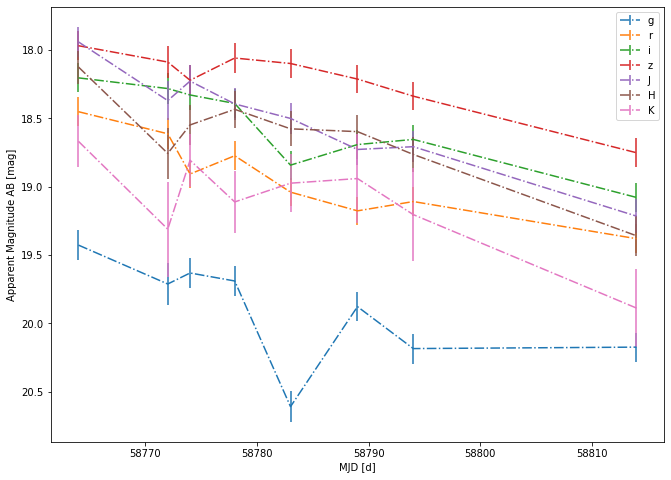

In [74]:
plt.figure(figsize=(11,8))
for band in 'grizJHK':
    lc = phot_tab.to_pandas().query('band == "%s"' % band)
    plt.errorbar(lc['mjd'], lc['mag_aper'], yerr=lc['magerr_aper'], label=band, fmt='-.')
plt.legend()
plt.gca().invert_yaxis()
plt.xlabel('MJD [d]')
plt.ylabel('Apparent Magnitude AB [mag]')
plt.savefig('2020-04-14-grond-lc-v1.png')
plt.savefig('../paper/playground/2020-04-14-grond-lc-v1.png')

In [81]:
phot_tab.write('2020-04-20-grond-lc-v1.h5', path='/lc')